In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from scipy.spatial import KDTree
from matplotlib import colors

In [2]:
# Custom code to load .list files
import stuff

In [3]:
stars, galaxies = stuff.parse_stuff_list('/home/aalvarez/Work/Data/sim09/sim09_r.list')

In [4]:
img = fits.open('/home/aalvarez/Work/Data/sim09/sim09_r_05.fits')[0]

We have now the baseline. We train a KDTree with their coordinates, so we can cross-reference

In [5]:
stars_coords = np.stack([stars.ra, stars.dec]).T
galaxies_coords = np.stack([galaxies.ra, galaxies.dec]).T
all_coords = np.append(stars_coords, galaxies_coords, axis=0)
all_kdtree = KDTree(all_coords)
all_mags = np.append(stars.mag, galaxies.mag)

n_stars = len(stars)
n_galaxies = len(galaxies)

Load the run with and without variable PSF

In [6]:
ocv_catalog = Table.read('/home/aalvarez/Work/Projects/sextractorxx/tests/sim09_ocv/sexpp.out.fits')
dft_catalog = Table.read('/home/aalvarez/Work/Projects/sextractorxx/tests/sim09/sexpp.out.fits')

Compute magnitudes

In [7]:
# This comes from sim09_r_sky.conf
mag_zeropoint = 26.
exp_time = 300.

In [8]:
ocv_catalog['mag'] = mag_zeropoint - 2.5 * np.log10(ocv_catalog['smf_total_flux'] / exp_time)
dft_catalog['mag'] = mag_zeropoint - 2.5 * np.log10(dft_catalog['smf_total_flux'] / exp_time)

## Residuals

In [9]:
ocv_residuals = fits.open('/home/aalvarez/Work/Projects/sextractorxx/tests/sim09_ocv/check_residual.fits')
dft_residuals = fits.open('/home/aalvarez/Work/Projects/sextractorxx/tests/sim09/check_residual.fits')

<IPython.core.display.Javascript object>


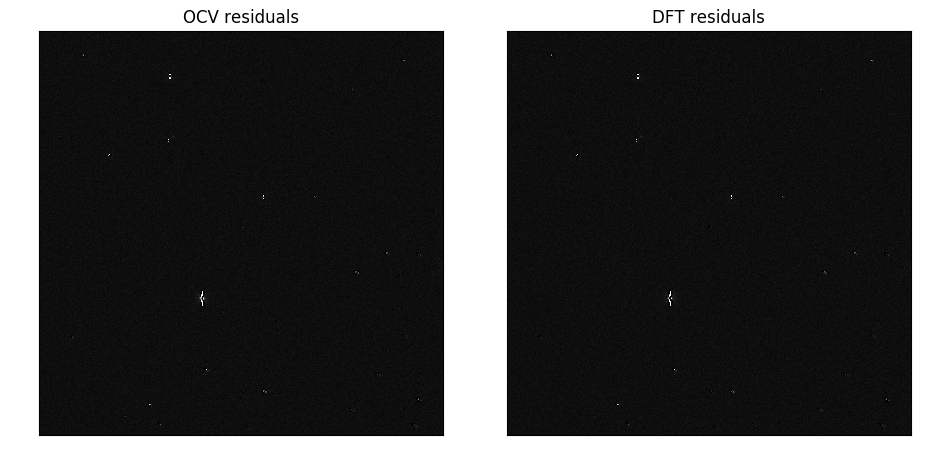

In [10]:
cmap = plt.get_cmap('Greys_r')
norm = colors.SymLogNorm(1200)
norm.autoscale(img.data)

plt.figure(figsize=(9.5, 4.5))

plt.subplot(121)
plt.imshow(ocv_residuals[0].data, cmap=cmap, norm=norm)
plt.title('OCV residuals')
_ = plt.xticks([])
_ = plt.yticks([])

plt.subplot(122)
plt.imshow(dft_residuals[0].data, cmap=cmap, norm=norm)
plt.title('DFT residuals')
_ = plt.xticks([])
_ = plt.yticks([])

plt.tight_layout()

## Compare results

In [11]:
def get_closest(catalog):
    distances = []
    index_c = []
    index_s = []
    for i, e in enumerate(catalog):
        d, s = all_kdtree.query([e['smf_alpha'], e['smf_delta']], 1)
        distances.append(d)
        index_c.append(i)
        index_s.append(s)
    return {
        'dist': np.array(distances),
        'catalog': np.array(index_c),
        'source': np.array(index_s),
    }

In [12]:
ocv_closest = get_closest(ocv_catalog)
dft_closest = get_closest(dft_catalog)

In [13]:
print("OCV | Number of sources found:", len(ocv_catalog))
print("DFT | Number of stars found:", len(dft_catalog))

OCV | Number of sources found: 346
DFT | Number of stars found: 346


In [14]:
def plot_stats(ax, data):
    ax.text(
        0.7, 0.7,
        '$\mu$: {:.3e}\n$\sigma$: {:.3e}\n$\%_{{50}}$: {:.3e}\n$\%_{{95}}$: {:.3e}'.format(
            np.average(data),
            np.std(data),
            np.median(data),
            np.percentile(data, 95)
        ),
        transform=ax.transAxes
    )

<IPython.core.display.Javascript object>


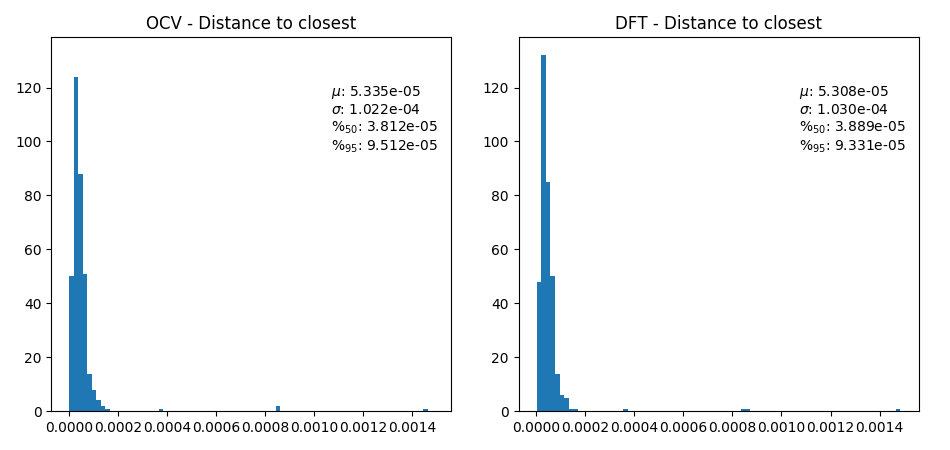

In [15]:
plt.figure(figsize=(9.5, 4.5))

ax1 = plt.subplot(1, 2, 1)
ax1.hist(ocv_closest['dist'], 80)
plot_stats(ax1, ocv_closest['dist'])
_ = ax1.set_title('OCV - Distance to closest')

ax2 = plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
ax2.hist(dft_closest['dist'], 80)
plot_stats(ax2, dft_closest['dist'])
_ = ax2.set_title('DFT - Distance to closest')

plt.tight_layout()

Overall, computed sources are closer to their closest original star with the variable PSF.

### Magnitudes

In [16]:
ocv_mag_diff = ocv_catalog['mag'] - all_mags[ocv_closest['source']]
dft_mag_diff = dft_catalog['mag'] - all_mags[dft_closest['source']]

<IPython.core.display.Javascript object>


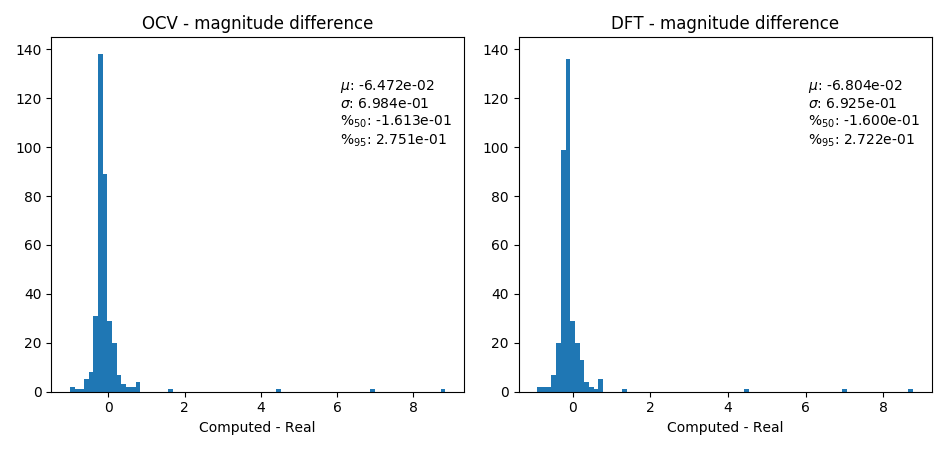

In [17]:
plt.figure(figsize=(9.5, 4.5))

ax1 = plt.subplot(1, 2, 1)
ax1.hist(ocv_mag_diff, 80)
ax1.set_xlabel('Computed - Real')
plot_stats(ax1, ocv_mag_diff)
ax1.set_title('OCV - magnitude difference')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
ax2.hist(dft_mag_diff, 80)
ax2.set_xlabel('Computed - Real')
plot_stats(ax2, dft_mag_diff)
_ = ax2.set_title('DFT - magnitude difference')

plt.tight_layout()

<IPython.core.display.Javascript object>


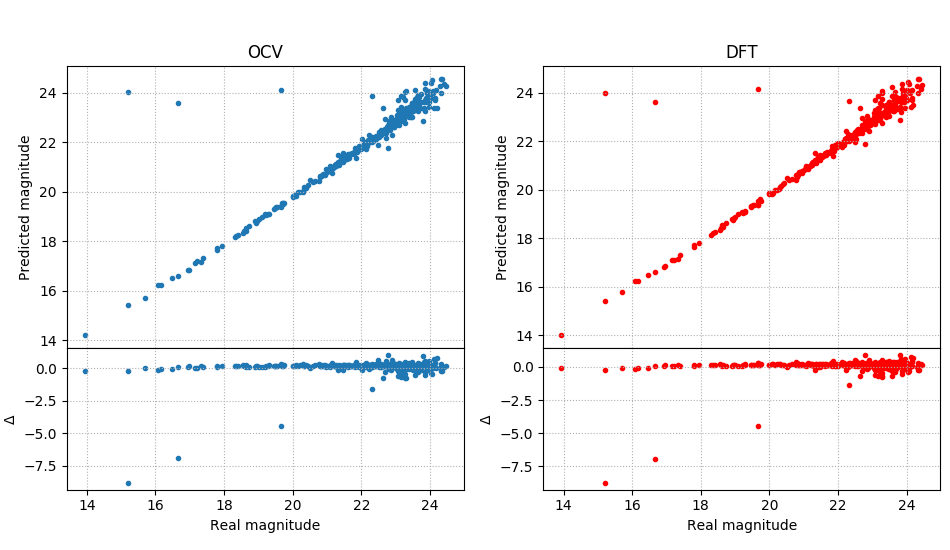

In [18]:
ocv_predicted_mag = ocv_catalog[ocv_closest['catalog']]['mag']
ocv_simulation_mag = all_mags[ocv_closest['source']]

dft_predicted_mag = dft_catalog[dft_closest['catalog']]['mag']
dft_simulation_mag = all_mags[dft_closest['source']]

plt.figure(figsize=(9.5, 5.5))
plt.subplots_adjust(left=0.07, right=0.99, hspace=0.0, wspace=0.2)

ax1 = plt.subplot2grid((3, 2), (0, 0), 2)
ax1.scatter(
    ocv_simulation_mag,
    ocv_predicted_mag,
    marker='.'
)
ax1.set_ylabel('Predicted magnitude')
ax1.set_xlabel('Real magnitude')
ax1.set_title('OCV')
ax1.grid(True, linestyle=':')

ax2 = plt.subplot2grid((3, 2), (2, 0), 1)
ax2.scatter(
    ocv_simulation_mag,
    ocv_simulation_mag - ocv_predicted_mag,
    marker='.'
)
ax2.set_ylabel('$\Delta$')
ax2.set_xlabel('Real magnitude')
ax2.grid(True, linestyle=':')

ax3 = plt.subplot2grid((3, 2), (0, 1), 2)
ax3.scatter(
    dft_simulation_mag,
    dft_predicted_mag,
    marker='.', c='r'
)
ax3.set_ylabel('Predicted magnitude')
ax3.set_title('DFT')
ax3.grid(True, linestyle=':')

ax4 = plt.subplot2grid((3, 2), (2, 1), 1)
ax4.scatter(
    dft_simulation_mag,
    dft_simulation_mag - dft_predicted_mag,
    marker='.', c='r'
)
ax4.set_ylabel('$\Delta$')
ax4.set_xlabel('Real magnitude')
ax4.grid(True, linestyle=':')

_ = 0